In [1]:
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 1. Read FULLSET FLUXNET

In [2]:
# list of sites
meta = {
    'Site': [],
    'Period': [],
    'DD_csv': [],
    'HH_csv': []
}
fhs = glob.glob(r'F:\EC_Data\FULLSET\*FLUXNET*_FULLSET_DD*.csv')

for fh in fhs:
    meta['DD_csv'].append(fh)
    meta['HH_csv'].append(fh.replace('_DD_','_HH_'))
    meta['Site'].append(os.path.basename(fh).split('_')[1])
    meta['Period'].append(os.path.basename(fh).split('_')[5])

In [3]:
datasets=pd.DataFrame(meta)
datasets

,Site,Period,DD_csv,HH_csv
0,AR-TF1,2016-2018,F:\EC_Data\FULLSET\AMF_AR-TF1_FLUXNET_FULLSET_...,F:\EC_Data\FULLSET\AMF_AR-TF1_FLUXNET_FULLSET_...
1,CA-Cbo,1994-2020,F:\EC_Data\FULLSET\AMF_CA-Cbo_FLUXNET_FULLSET_...,F:\EC_Data\FULLSET\AMF_CA-Cbo_FLUXNET_FULLSET_...
2,CA-DB2,2019-2020,F:\EC_Data\FULLSET\AMF_CA-DB2_FLUXNET_FULLSET_...,F:\EC_Data\FULLSET\AMF_CA-DB2_FLUXNET_FULLSET_...
3,CA-DBB,2014-2020,F:\EC_Data\FULLSET\AMF_CA-DBB_FLUXNET_FULLSET_...,F:\EC_Data\FULLSET\AMF_CA-DBB_FLUXNET_FULLSET_...
4,CA-ER1,2015-2020,F:\EC_Data\FULLSET\AMF_CA-ER1_FLUXNET_FULLSET_...,F:\EC_Data\FULLSET\AMF_CA-ER1_FLUXNET_FULLSET_...
...,...,...,...,...
267,SE-Nor,2014-2020,F:\EC_Data\FULLSET\FLX_SE-Nor_FLUXNET2015_FULL...,F:\EC_Data\FULLSET\FLX_SE-Nor_FLUXNET2015_FULL...
268,SE-Ros,2014-2018,F:\EC_Data\FULLSET\FLX_SE-Ros_FLUXNET2015_FULL...,F:\EC_Data\FULLSET\FLX_SE-Ros_FLUXNET2015_FULL...
269,SE-Ros,2014-2020,F:\EC_Data\FULLSET\FLX_SE-Ros_FLUXNET2015_FULL...,F:\EC_Data\FULLSET\FLX_SE-Ros_FLUXNET2015_FULL...
270,SE-Svb,2014-2018,F:\EC_Data\FULLSET\FLX_SE-Svb_FLUXNET2015_FULL...,F:\EC_Data\FULLSET\FLX_SE-Svb_FLUXNET2015_FULL...


## READ files

- FLUXNET_FULLSET metadata: https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/

In [4]:
row=datasets.iloc[0]
print(row['DD_csv'])
print(row['HH_csv'])

F:\EC_Data\FULLSET\AMF_AR-TF1_FLUXNET_FULLSET_DD_2016-2018_3-5.csv
F:\EC_Data\FULLSET\AMF_AR-TF1_FLUXNET_FULLSET_HH_2016-2018_3-5.csv


In [5]:
# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

df_HH = pd.read_csv(row['HH_csv'], parse_dates=['TIMESTAMP_START'], na_values = -9999)
ds_HH = df_HH.rename(columns={'TIMESTAMP_START':'time'}).set_index('time').to_xarray()

In [6]:
# key variables for ET calculation
DD_variables = [
'LE_F_MDS', #Latent heat flux, gapfilled using MDS method, average from half-hourly data [W m-2]
'LE_F_MDS_QC', #Quality flag for LE_F_MDS, LE_CORR, LE_CORR25, and LE_CORR75. fraction between 0-1, indicating percentage of measured and good quality gapfill data (QC=1)
'LE_CORR', # Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor, average from half-hourly data [W m-2] 
'LE_CORR_25', # Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor, 25th percentile
'LE_CORR_75', # Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor, 75th percentile
'LE_RANDUNC', # Random uncertainty of LE, from measured only data. from random uncertainty of individual half-hours (rand(i)) = [SQRT(SUM(rand(i)^2)) / n], where n is the number of half-hours used [W m-2]
'TA_F_MDS' # Air temperature, gapfilled using MDS method (deg C)
'TA_F_MDS_QC' # Quality flag for TA_F_MDS, fraction between 0-1, indicating percentage of measured and good quality gapfill data (QC = 1)
                ]

HH_variables = [
'LE_F_MDS', #Latent heat flux, gapfilled using MDS method, average from half-hourly data [W m-2]
'LE_F_MDS_QC', #Quality flag for LE_F_MDS, LE_CORR, LE_CORR25, and LE_CORR75. 0 = measured; 1 = good quality gapfill; 2 = medium; 3 = poor
'LE_CORR', # Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor, average from half-hourly data [W m-2] 
'LE_CORR_25', # Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor, 25th percentile
'LE_CORR_75', # Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor, 75th percentile
'LE_RANDUNC', # Random uncertainty of LE, uses only data point where LE_F_MDS_QC is 0 and two hierarchical methods (see header and LE_RANDUNC_METHOD)
'LE_RANDUNC_METHOD', # Method used to estimate the random uncertainty of LE, 1 = RANDUNC Method 1 (direct SD method), 2 = RANDUNC Method 2 (median SD method)     
'TA_F_MDS' # Air temperature, gapfilled using MDS method (deg C)
'TA_F_MDS_QC' # Quality flag for TA_F_MDS, 0 = measured; 1 = good quality gapfill; 2 = medium; 3 = poor
                ]

# 2. Calculate daily ET

## Method codes
1. Processing high-frequency data (10-20Hz) to half-hourly
- (A) ONEFLUX suite outputs
<!-- - (B) easyflux outputs -->
<!-- - (C) Ozflux?? -->

2. Correcting half-hourly LE
  
(A)
- [x] (a) Gap-filled, no correction: LE_F_MSD 
- [x] (b) ONEFLUX Energy Balance correction: LE_CORR
<!-- - [ ] (c) Zhang2024: HRHC + AEC + BowenRatio -->
<!-- - [ ] (d) OpenET -->

3. Processing half-hourly LE data to daily ET

(I) Average HH LE to Daily LE, then convert to daily ET
- [x] (i) assume constant lambda
- [x] (ii) calculate lambda from daily average Ta

(II) Convert HH LE to HH ET (mm h-1), then aggregate to daily ET (mm d-1)
- [x] (i) filter gaps => average (threshold: % gap per day)
<!-- - [ ] (ii) fill gap => sum gap-filled hours -->

4. Processing daily ET (mm d-1) to dekadal average ET (mm d-1)
- [ ] (1) filter day gaps
- [ ] (2) fill day gaps

In [13]:
def LE_to_ET(le,lmbd,rho=1000,dT=86400): 
    """
    Aggregate half-hourly LE (W m-2) to daily LE (W m-2)

    Parameters
    ----------
    le: xarray.DataArray
        Latent heat energy (W m-2) or (J s-1 m-2)
    lmbd: float or xarray.DataArray
        Latent heat of vaporization (J kg-1)
    rho: float or xarray.DataArray
        Density of water (kg m-3)
        1000 kg m-3 under standard condition (at 4 deg C) 
    dT: int
        Number of seconds per time step
        86400 s d-1  
    Returns
    -------
    et: xarray.DataArray
        Total evapotranspiration (mm dT-1)
    """
    et_s = ((le/lmbd*rho)*1e-3) #mm s-1
    et = et_s * dT # mm dT-1
    return et
    
def latent_heat_vaporization(T,method='Allen1998'): # (2)
    """
    Latent heat of vaporization  as a function of air temperature (deg C)

    Parameters
    ----------
    method: str
        Method from references
    T: list or array
        Air temperature (deg C)    

    References
    ----------
    - Stull, B., 1988: An Introduction to Boundary Layer Meteorology (p.641)
      Kluwer Academic Publishers, Dordrecht, Netherlands
    - Foken, T, 2008: Micrometeorology. Springer, Berlin, Germany.
    - Allen, R.G., Pereira, L.S., Raes, D., Smith, M., 1998. Crop evapotranspiration - Guidelines for computing crop water requirements, FAO Irrigation and drainage paper. FAO - Food and Agriculture Organization of the United Nations, Rome.
    """
    # Use constant
    if method == 'Allen1998':
        lmbd = 2.45*1e+06 # 2.45 MJ kg-1 for T = 20 deg C
    # Use the formula lmbd = (2.501 - 0.00237 * Tair)*10^6
    if method == 'Stull1988':
        k1 = 2.501
        k2 = 0.00237
        lmbd = (k1 - k2 *T) *1e+06
    return lmbd
    
def resample_dekadal(df_daily,method='mean'):
    '''
    method: str
        'mean'  = daily average of dekad
    '''
    
    from dateutil.relativedelta import relativedelta
    start=df_daily.index[0]
    end=df_daily.index[-1]    
    date_range = pd.date_range(start=start, end=end, freq='MS')
    specific_dates = [date + relativedelta(days=10 * i) for date in date_range for i in range(3)]
    df_specific_dates = pd.DataFrame(index=specific_dates, columns=['Data'])
    df_resampled = pd.DataFrame(index=df_specific_dates.index, 
                                columns=list(df_daily.columns))
    # Resample the daily dataframe for each specific date in the second dataframe
    for date in df_specific_dates.index:
        if date == df_specific_dates.index[-1]:
            # For the last date, include all remaining days
            resampled_data = df_daily.loc[date:]
        else:
            next_date = df_specific_dates.index[df_specific_dates.index > date][0]
            resampled_data = df_daily.loc[date:next_date - pd.Timedelta(days=1)]

        # Calculate the mean for the specific date range and store it in the resampled dataframe
        for col in list(df_daily.columns):
            df_resampled.loc[date, col] = resampled_data[col].aggregate(method)    
    return df_resampled

In [ ]:
{'AaIi': 'ONEFlux-LE_F_MSD-DailyAvgLE-Const_lambda',
'AaIii':'ONEFlux-LE_F_MSD-DailyAvgLE-Ta_lambda',
'AbIi':'ONEFlux-LE_CORR-DailyAvgLE-Const_lambda',
'AbIii':'ONEFlux-LE_CORR-DailyAvgLE-Ta_lambda',
'AaIIi':'ONEFlux-LE_F_MSD-AggHourlyET-Const_lambda',
'AbIIi':'ONEFlux-LE_CORR-AggHourlyET-Const_lambda'}

## Hourly LE to daily ET

In [8]:
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

### A-x-II-x
lmbd = latent_heat_vaporization(ds_HH['TA_F_MDS'], method='Stull1988')

## A-a-II
et_hh_AaII=LE_to_ET(ds_HH['LE_F_MDS'],lmbd,rho=1000,dT=1800) # [mm hh-1]
# A-a-II-i 
et_hh_AaIIi = et_hh_AaII[ds_HH['LE_F_MDS_QC']<2]
et_dd_AaIIi = 48*et_hh_AaIIi.resample(time='1D').mean() # [mm d-1]
# A-a-II-ii TODO


## A-b-II
et_hh_AbII=LE_to_ET(ds_HH['LE_CORR'],lmbd,rho=1000,dT=1800) # [mm hh-1]
# A-b-II-i
et_hh_AbIIi = et_hh_AbII[ds_HH['LE_F_MDS_QC']<2]
et_dd_AbIIi = 48*et_hh_AbIIi.resample(time='1D').mean() # [mm d-1]
# A-b-II-ii TODO


## Daily ET to dekadal ET

In [22]:
def ds_daily_to_df_dekadal(ds_daily,name=''):
    ds_daily.name = name
    df_daily = ds_daily.to_dataframe()
    df_dekadal = resample_dekadal(df_daily)
    df_dekadal.index.names = ['Date']
    return df_dekadal

In [12]:
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIIi,
'AbIIi':et_dd_AbIIi
}
for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')

## Compare results

<Axes: xlabel='Date'>

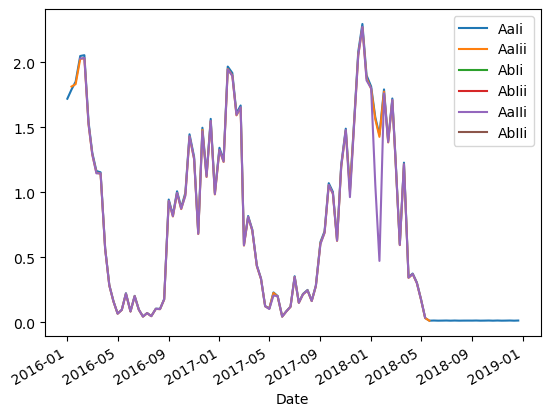

In [13]:
df.plot()

# 3. Apply to all FLUXNET2022 sites

In [14]:
for i in datasets.index.values:
    # if i <= 58:
    #     continue
    try:
        row=datasets.iloc[i]
        print(row)
        # read csv file as xarray dataset
        df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
        ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()
        
        df_HH = pd.read_csv(row['HH_csv'], parse_dates=['TIMESTAMP_START'], na_values = -9999)
        ds_HH = df_HH.rename(columns={'TIMESTAMP_START':'time'}).set_index('time').to_xarray()
        
    ## Hourly LE to daily ET
        # A-a-I-i
        lmbd = latent_heat_vaporization(None, method='Allen1998')
        et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)
        
        # A-a-I-ii
        lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
        et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)
        
        # A-b-I-i
        lmbd = latent_heat_vaporization(None, method='Allen1998')
        et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)
        
        # A-b-I-ii
        lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
        et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)
        
        ### A-x-II-x
        lmbd = latent_heat_vaporization(ds_HH['TA_F_MDS'], method='Stull1988')
        
        ## A-a-II
        et_hh_AaII=LE_to_ET(ds_HH['LE_F_MDS'],lmbd,rho=1000,dT=1800) # [mm hh-1]
        # A-a-II-i 
        et_hh_AaIIi = et_hh_AaII[ds_HH['LE_F_MDS_QC']<2]
        et_dd_AaIIi = 48*et_hh_AaIIi.resample(time='1D').mean() # [mm d-1]
        # A-a-II-ii TODO
        
        
        ## A-b-II
        et_hh_AbII=LE_to_ET(ds_HH['LE_CORR'],lmbd,rho=1000,dT=1800) # [mm hh-1]
        # A-b-II-i
        et_hh_AbIIi = et_hh_AbII[ds_HH['LE_F_MDS_QC']<2]
        et_dd_AbIIi = 48*et_hh_AbIIi.resample(time='1D').mean() # [mm d-1]
        # A-b-II-ii TODO

    ## Add results of all methods to one dataset
        ds_dict={
        'AaIi':et_dd_AaIi,
        'AaIii':et_dd_AaIii,
        'AbIi':et_dd_AbIi,
        'AbIii':et_dd_AbIii,
        'AaIIi':et_dd_AaIIi,
        'AbIIi':et_dd_AbIIi
        }
    
        for i,key in enumerate(ds_dict.keys()):
            ds_daily=ds_dict[key]
            df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
            if i == 0:
                df = df_dekadal
            else:
                df = pd.merge(df,df_dekadal,on='Date',how='outer')
    ##SAVE
        df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')
    except Exception as e:
        print(i)
        print(e)

Site                                                 AR-TF1
Period                                            2016-2018
DD_csv    E:\EC_Data\FULLSET\AMF_AR-TF1_FLUXNET_FULLSET_...
HH_csv    E:\EC_Data\FULLSET\AMF_AR-TF1_FLUXNET_FULLSET_...
Name: 0, dtype: object
Site                                                 CA-Cbo
Period                                            1994-2020
DD_csv    E:\EC_Data\FULLSET\AMF_CA-Cbo_FLUXNET_FULLSET_...
HH_csv    E:\EC_Data\FULLSET\AMF_CA-Cbo_FLUXNET_FULLSET_...
Name: 1, dtype: object
Site                                                 CA-DB2
Period                                            2019-2020
DD_csv    E:\EC_Data\FULLSET\AMF_CA-DB2_FLUXNET_FULLSET_...
HH_csv    E:\EC_Data\FULLSET\AMF_CA-DB2_FLUXNET_FULLSET_...
Name: 2, dtype: object
Site                                                 CA-DBB
Period                                            2014-2020
DD_csv    E:\EC_Data\FULLSET\AMF_CA-DBB_FLUXNET_FULLSET_...
HH_csv    E:\EC_Data\FULLSET\AM

**Exceptions**
- [x] 30: Ha1 process hourly instead of half-hourly: AMF_US-Ha1_FLUXNET_FULLSET_HR_1991-2020_3-5.csv
- [x] 49: AMF_US-MMS_FLUXNET_FULLSET_HR_1999-2020_3-5.csv
- [x] 55: US-Myb missing ds_HH['LE_F_MDS_QC']
- [x] 58: [Errno 2] No such file or directory: 'E:\\EC_Data\\FULLSET\\AMF_US-Ne1_FLUXNET_FULLSET_HH_2001-2020_3-5.csv'
- [x] 189: DE-Hte, missing ds_HH['LE_F_MDS_QC'], LE_CORR
- [x] 93: US-Wjs, missing ds_HH['LE_F_MDS_QC'], LE_CORR
- [x] 229: FR-EM2, missing ds_HH['LE_F_MDS_QC'], LE_CORR

# 4. Exceptions

Out of 222 stations, 2 stations have hourly data instead of half-hourly data. 5 stations missing half-hourly LE_CORR and LE_F_MDS_QC. We compared the results constant latent heat versus latent heat with air temperature correction at these stations, the difference between resulted ET is minimal. 

# Exception stations

- 'US-MMS': data are hourly instead of half-hourly, processed hourly data instead
- 'US-Ne1': data are hourly instead of half-hourly, processed hourly data instead
- 'DE-Hte': missing ds_HH['LE_F_MDS_QC'], only processed daily data
- 'US-Wjs': missing ds_HH['LE_F_MDS_QC'], only processed daily data
- 'FR-EM2': missing ds_HH['LE_F_MDS_QC'], only processed daily data
- 'US-Myb': missing ds_HH['LE_F_MDS_QC'], only processed daily data
- 'US-Ha1': data are hourly instead of half-hourly, hourly data missing 'LE_F_MDS_QC' and LE_CORR, only processed daily data

## FR-EM2

In [95]:
i = 229
row=datasets.iloc[i]
print(row)

Site                                                 FR-EM2
Period                                            2017-2018
DD_csv    F:\EC_Data\FULLSET\FLX_FR-EM2_FLUXNET2015_FULL...
HH_csv    F:\EC_Data\FULLSET\FLX_FR-EM2_FLUXNET2015_FULL...
Name: 229, dtype: object


In [96]:
# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)


## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIi*np.nan,
'AbIIi':et_dd_AaIi*np.nan    
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')

## US-Wjs

In [97]:
i = 93
row=datasets.iloc[i]
print(row)

Site                                                 US-Wjs
Period                                            2007-2021
DD_csv    F:\EC_Data\FULLSET\AMF_US-Wjs_FLUXNET_FULLSET_...
HH_csv    F:\EC_Data\FULLSET\AMF_US-Wjs_FLUXNET_FULLSET_...
Name: 93, dtype: object


In [98]:
# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)


## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIi*np.nan,
'AbIIi':et_dd_AaIi*np.nan       
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')

## DE-Hte

In [99]:
i = 189
row=datasets.iloc[i]
print(row)

Site                                                 DE-Hte
Period                                            2009-2018
DD_csv    F:\EC_Data\FULLSET\FLX_DE-Hte_FLUXNET2015_FULL...
HH_csv    F:\EC_Data\FULLSET\FLX_DE-Hte_FLUXNET2015_FULL...
Name: 189, dtype: object


In [100]:

# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)


## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIi*np.nan,
'AbIIi':et_dd_AaIi*np.nan       
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')

## US-Ne1

In [101]:
i = 58
row=datasets.iloc[i]
print(row)

Site                                                 US-Ne1
Period                                            2001-2020
DD_csv    F:\EC_Data\FULLSET\AMF_US-Ne1_FLUXNET_FULLSET_...
HH_csv    F:\EC_Data\FULLSET\AMF_US-Ne1_FLUXNET_FULLSET_...
Name: 58, dtype: object


In [102]:
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()
corrected_path = row['HH_csv'].replace('HH','HR')
df_HH = pd.read_csv(corrected_path, parse_dates=['TIMESTAMP_START'], na_values = -9999)
ds_HH = df_HH.rename(columns={'TIMESTAMP_START':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

### A-x-II-x
lmbd = latent_heat_vaporization(ds_HH['TA_F_MDS'], method='Stull1988')

## A-a-II
et_hh_AaII=LE_to_ET(ds_HH['LE_F_MDS'],lmbd,rho=1000,dT=3600) # [mm hh-1]
# A-a-II-i 
et_hh_AaIIi = et_hh_AaII[ds_HH['LE_F_MDS_QC']<2]
et_dd_AaIIi = 24*et_hh_AaIIi.resample(time='1D').mean() # [mm d-1]
# A-a-II-ii TODO


## A-b-II
et_hh_AbII=LE_to_ET(ds_HH['LE_CORR'],lmbd,rho=1000,dT=3600) # [mm hh-1]
# A-b-II-i
et_hh_AbIIi = et_hh_AbII[ds_HH['LE_F_MDS_QC']<2]
et_dd_AbIIi = 24*et_hh_AbIIi.resample(time='1D').mean() # [mm d-1]
# A-b-II-ii TODO

## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIIi,
'AbIIi':et_dd_AbIIi
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')

## US-Myb

In [103]:
i = 55
row=datasets.iloc[i]
print(row)

Site                                                 US-Myb
Period                                            2010-2021
DD_csv    F:\EC_Data\FULLSET\AMF_US-Myb_FLUXNET_FULLSET_...
HH_csv    F:\EC_Data\FULLSET\AMF_US-Myb_FLUXNET_FULLSET_...
Name: 55, dtype: object


In [104]:

# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)


## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIi*np.nan,
'AbIIi':et_dd_AaIi*np.nan       
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')

## US-MMS

In [105]:
i = 49
row=datasets.iloc[i]
print(row)

Site                                                 US-MMS
Period                                            1999-2020
DD_csv    F:\EC_Data\FULLSET\AMF_US-MMS_FLUXNET_FULLSET_...
HH_csv    F:\EC_Data\FULLSET\AMF_US-MMS_FLUXNET_FULLSET_...
Name: 49, dtype: object


In [106]:
corrected_path = row['HH_csv'].replace('HH','HR')
corrected_path

'F:\\EC_Data\\FULLSET\\AMF_US-MMS_FLUXNET_FULLSET_HR_1999-2020_3-5.csv'

In [107]:
# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

df_HH = pd.read_csv(corrected_path, parse_dates=['TIMESTAMP_START'], na_values = -9999)
ds_HH = df_HH.rename(columns={'TIMESTAMP_START':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

### A-x-II-x
lmbd = latent_heat_vaporization(ds_HH['TA_F_MDS'], method='Stull1988')

## A-a-II
et_hh_AaII=LE_to_ET(ds_HH['LE_F_MDS'],lmbd,rho=1000,dT=3600) # [mm hh-1]
# A-a-II-i 
et_hh_AaIIi = et_hh_AaII[ds_HH['LE_F_MDS_QC']<2]
et_dd_AaIIi = 24*et_hh_AaIIi.resample(time='1D').mean() # [mm d-1]
# A-a-II-ii TODO


## A-b-II
et_hh_AbII=LE_to_ET(ds_HH['LE_CORR'],lmbd,rho=1000,dT=3600) # [mm hh-1]
# A-b-II-i
et_hh_AbIIi = et_hh_AbII[ds_HH['LE_F_MDS_QC']<2]
et_dd_AbIIi = 24*et_hh_AbIIi.resample(time='1D').mean() # [mm d-1]
# A-b-II-ii TODO

## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIIi,
'AbIIi':et_dd_AbIIi
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')

## US-Ha1

In [108]:
i = 30
row=datasets.iloc[i]
print(row)

Site                                                 US-Ha1
Period                                            1991-2020
DD_csv    F:\EC_Data\FULLSET\AMF_US-Ha1_FLUXNET_FULLSET_...
HH_csv    F:\EC_Data\FULLSET\AMF_US-Ha1_FLUXNET_FULLSET_...
Name: 30, dtype: object


In [109]:
corrected_path = row['HH_csv'].replace('HH','HR')
corrected_path

'F:\\EC_Data\\FULLSET\\AMF_US-Ha1_FLUXNET_FULLSET_HR_1991-2020_3-5.csv'

In [110]:

# read csv file as xarray dataset
df_DD = pd.read_csv(row['DD_csv'], parse_dates=['TIMESTAMP'], na_values = -9999)
ds_DD = df_DD.rename(columns={'TIMESTAMP':'time'}).set_index('time').to_xarray()

## Hourly LE to daily ET
# A-a-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AaIi=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-a-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AaIii=LE_to_ET(ds_DD['LE_F_MDS'],lmbd,rho=1000,dT=86400)

# A-b-I-i
lmbd = latent_heat_vaporization(None, method='Allen1998')
et_dd_AbIi=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)

# A-b-I-ii
lmbd = latent_heat_vaporization(ds_DD['TA_F_MDS'], method='Stull1988')
et_dd_AbIii=LE_to_ET(ds_DD['LE_CORR'],lmbd,rho=1000,dT=86400)


## Add results of all methods to one dataset
ds_dict={
'AaIi':et_dd_AaIi,
'AaIii':et_dd_AaIii,
'AbIi':et_dd_AbIi,
'AbIii':et_dd_AbIii,
'AaIIi':et_dd_AaIIi,
'AbIIi':et_dd_AbIIi
}

for i,key in enumerate(ds_dict.keys()):
    ds_daily=ds_dict[key]
    df_dekadal = ds_daily_to_df_dekadal(ds_daily,name=key)
    if i == 0:
        df = df_dekadal
    else:
        df = pd.merge(df,df_dekadal,on='Date',how='outer')
##SAVE
df.to_csv(f'Data/FLUXNET/FLUXNET2022/{row['Site']}.csv')


# X. plot gap-filled LE, EB-corrected LE, and random uncertainty

In [58]:
EB_closure_C = (ds['LE_CORR']+ds['H_CORR'])/(ds['NETRAD']-ds['G_F_MDS'])
EB_closure = (ds['LE_F_MDS']+ds['H_F_MDS'])/(ds['NETRAD']-ds['G_F_MDS'])

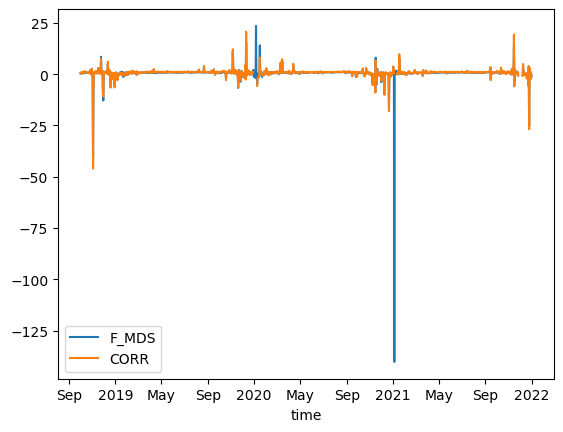

In [59]:
EB_closure.plot(label='F_MDS')
EB_closure_C.plot(label='CORR')
plt.legend()

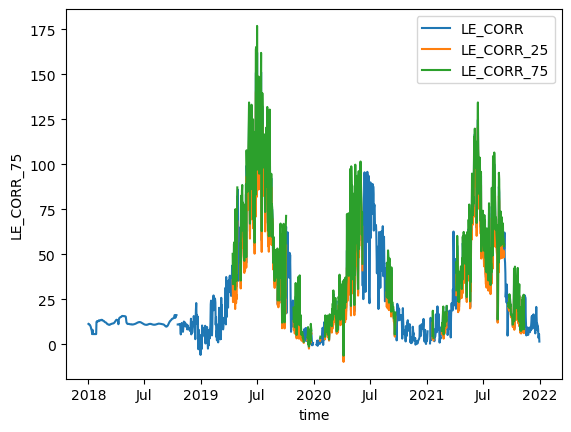

In [60]:
ds['LE_CORR'].plot(label='LE_CORR')
ds['LE_CORR_25'].plot(label='LE_CORR_25')
ds['LE_CORR_75'].plot(label='LE_CORR_75')
plt.legend()

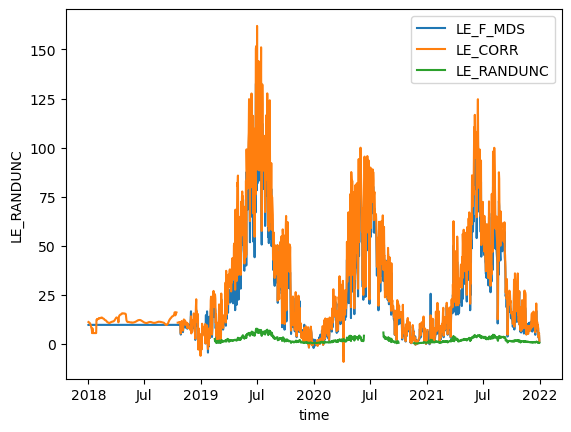

In [61]:
ds['LE_F_MDS'].plot(label='LE_F_MDS')
ds['LE_CORR'].plot(label='LE_CORR')
ds['LE_RANDUNC'].plot(label='LE_RANDUNC')
plt.legend()

In [62]:
RMSE_pct= ds['LE_RANDUNC']/ds['LE_F_MDS']
RMSE_pct.min()

<xarray.DataArray ()> Size: 8B
array(-98.3692106)